If viewing this on GitHub and the notebook is not rendering correctly then try:
https://nbviewer.org/github/CMGreenspon/BCIDetectionThresholdSimulations/blob/main/DetectionThresholdNotebook.ipynb

In [22]:
# Imports
using DataFrames, Plots, StatsBase, Distributions, Statistics, LsqFit, Distributed,
      NaNStatistics, Base.Threads, ColorSchemes, Measures
include.(("ConstantSimulations.jl", "StaircaseSimulations.jl"))

# Psychophysics helper functions
jnd2sigma(j::Real) = (1 /quantile(Normal(), 0.75)) * j # Convert JND to σ
sigma2k(sigma::Real) = 1.7 / sigma; # Convert σ to k
sigmoid(x::Vector, coeffs::Vector) = 1 ./ (1 .+ exp.(-coeffs[1].*(x.-coeffs[2])))

# Plotting defaults
font = Plots.font("Helvetica", 9, "rgb(200,200,200)")
gr() # GR backend
gr(guidefont=font, xtickfont=font, ytickfont=font, annotationfontfamily=font, annotationfontsize=9,
legend=false, background_color = "rgb(30,30,30)", linewidth=2)

# Number of permutations for simulations
num_constant_perms = Int(1e3)
num_stair_perms = Int(1e3);

##### Defining the Psychometric Function
We first define an example psychophysical response function defined as a cumulative normal distribution where we define the detection threshold (μ) and just noticeable difference (which we then convert to σ). You can edit the 'detection_threshold' and 'jnd' values and re-run the cell to see how the shape of the psychometric curve changes. Note that the JND is defined as half of the distance between p(.75) and p(.25) stimulus levels. Thus, on the graph below the JND lines indicate the p(.25) and p(.75) values, but the JND is half range between them.

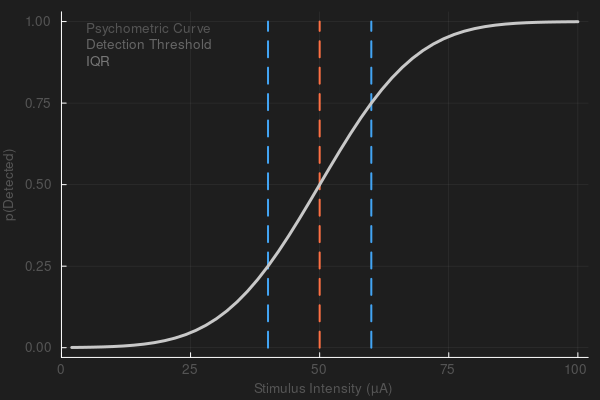

In [2]:
valid_stims = collect(2:2:100) # These are the amplitudes that can be given 
detection_threshold = 50 # microamps
jnd = 10 # microamps
sigma = jnd2sigma(jnd) # Convert for producing normal distribution
psychometric_pdf = Normal(detection_threshold, sigma) # The normal distribution
pDetected = cdf(psychometric_pdf, valid_stims) # Response probability at each stimulus

labels = ["Psychometric Curve", "Detection Threshold", "IQR"]
label_colors = ["rgb(200,200,200)", "rgb(255, 112, 67)", "rgb(66, 165, 245)"]

GroundTruthPlot = plot(xlabel = "Stimulus Intensity (μA)",ylabel = "p(Detected)", xlim=(0, 102))
    plot!(GroundTruthPlot, [detection_threshold, detection_threshold], [0, 1],
     linecolor = "rgb(255, 112, 67)", linestyle = :dash, linewidth = 2)
    plot!(GroundTruthPlot, [detection_threshold, detection_threshold].- jnd, [0, 1],
        color = "rgb(66, 165, 245)", linewidth = 2, linestyle = :dash) # detection_threshold
    plot!(GroundTruthPlot, [detection_threshold, detection_threshold].+ jnd, [0, 1],
        color = "rgb(66, 165, 245)", linewidth = 2, linestyle = :dash) # JND/Inter-quartile range
    plot!(GroundTruthPlot, valid_stims, pDetected, linecolor="rgb(200,200,200)", linewidth = 3)

    yl = 1; y_dec = .05
    for (l,c) in zip(labels, label_colors)
        annotate!(GroundTruthPlot, 5, yl, l, annotationhalign=:left, annotationvalign=:top, annotationcolor=c)
        yl -= y_dec
    end
display(GroundTruthPlot)

##### Unconstrained Method of Constants:
With no prior knowledge of the psychometric curve we have to span the full range of stimuli and sample the response probability at each stimulus level. Importantly, we will always simulate this as an 2-Alternate Forced Choice (2AFC) experiment as this is the most commonly used format as it minimizes response bias without extending the duration of the experiment excessively. This means that there is a chance (1/#AFC) that the testee will select the correct interval randomly. Thus, the p(Detected) needs to be adjusted to account for this. This reduces probability bias but, as can be seen below, massively increases the variability in the measured p(Detected).

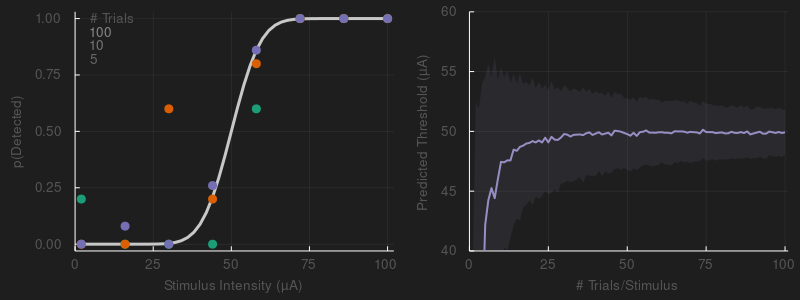

In [4]:
# Here we will choose which stimulus levels to test at
test_stims, test_stims_pDetected = GetConstantTargets(valid_stims, pDetected, Mode = "Unconstrained")
# Prepare plot
ConstantExamplePlot = plot(xlabel = "Stimulus Intensity (μA)", ylabel = "p(Detected)", xlim=(0, 102),
 size=(600,350))
    plot!(ConstantExamplePlot, valid_stims, pDetected, linecolor="rgb(200,200,200)", linewidth = 3)
    # Show for each number of trial
    yl = .85; y_dec = .06
    for (i,num_trials) in enumerate([5, 10, 100])
        _, pd = ConstantSimulation(test_stims, test_stims_pDetected, num_trials, NumPermutations = 1, NumAFC = 2)
        scatter!(ConstantExamplePlot, test_stims, vec(pd),  marker=:circle, markersize=5, markeralpha=1,
        markercolor=ColorSchemes.Dark2_3[i], markerstrokecolor=ColorSchemes.Dark2_3[i])
        annotate!(ConstantExamplePlot, 5, yl, num_trials, annotationhalign=:left, annotationvalign=:top,
        annotationcolor=markerstrokecolor=ColorSchemes.Dark2_3[i])
        yl = yl + y_dec
    end
    annotate!(ConstantExamplePlot, 5, yl, "# Trials",
    annotationhalign=:left, annotationvalign=:top, annotationcolor="rgb(200,200,200)")

# Now we'll simulate the predictions as a function of # trials
max_repeats_per_intensity = 100 # A beyond reasonable number of trials

# Simulate the method of constants
constant_num_trials_t_est = fill(NaN, max_repeats_per_intensity, num_constant_perms)
Threads.@threads for MaxReps = 1:max_repeats_per_intensity
    constant_num_trials_t_est[MaxReps,:], _ = ConstantSimulation(test_stims, test_stims_pDetected,
    MaxReps, NumPermutations = num_constant_perms, NumAFC = 2, BoundSig=false)
end
# Compute stats across permutations
t_mean_uconsts = vec(nanmean(constant_num_trials_t_est, dims = 2))
t_std_uconsts = vec(nanstd(constant_num_trials_t_est, dims = 2))
t_error_uconsts = vec(nanmean(abs.(constant_num_trials_t_est .- detection_threshold), dims = 2))

x = collect(1:max_repeats_per_intensity)
ConstantsNumTrialsPlot = plot(xlabel = "# Trials/Stimulus", ylabel = "Predicted Threshold (μA)",
  xlim=(0, max_repeats_per_intensity+1), ylim=(40,60), size=(800,350))
  plot!(ConstantsNumTrialsPlot, x, t_mean_uconsts, ribbon=t_std_uconsts, fillalpha=0.1, linewidth=2,
    linecolor=ColorSchemes.PuOr_3[3], fillcolor=ColorSchemes.PuOr_3[3])

plot(ConstantExamplePlot, ConstantsNumTrialsPlot, bottom_margin=5mm, left_margin=5mm, size=(800, 300))

Given that we used a 2AFC-task above, even with 100 trials we don't perfectly capture the distribution every time. You can re-run the cell to see how much variation there is, something that isn't present when NumAFC = 1, though that suffers from response bias. Simulating how our predictions change as a function of repeats we see that our average prediction is pretty close almost straight away, but the range of predictions is pretty substantial unless we have many repeats at each stimulus level.

##### Adaptive Methods: Transformed Staircase
The alternative approach is to 'adapt' to the responses and adjust the stimuli according to session history. One of the most popular approaches is the transformed staircase. In this approach you set a criteria and adjust the stimulus level once the criterion has been reached. The standard method is a 3U/1D staircase where the stimulus level decreases when the response is correct 3 times in a row and increases when the response is incorrect 1 time in a row. Each time the direction that the staircase is moving changes we count this after a reversion. The staircase will stop after a set number of reversions.

Importantly, each criterion will converge at a different location as will the task design. For example, 1-interval task with 1U/1D criterion will converge at 50%. However, a 2AFC task will 'converge' at 50% when no stimulus is present. Similarly, a 3U/1D criterion in 1-interval will target ~75%, but in 2AFC will target ~56%.

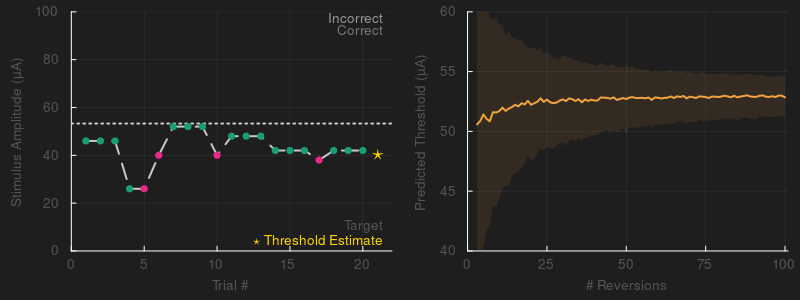

In [6]:
criterion = [3,1]
num_afc = 2
target_p = GetTransformedStaircaseTarget(num_afc, criterion)
target_amplitude = quantile(Normal(detection_threshold, sigma), target_p)
# Single staircase simulation
amplitude_history, detection_history, reversion_history, estimated_thresholds, stop_point = 
 TransformedStaircaseSimulation(valid_stims,  pDetected, Criterion = criterion,
  MaxReversions = 7, NumPermutations = 1, NumAFC = num_afc, UseMLE = false) 
# Identify which trials were correct/incorrect
term_idx = findfirst(isnan.(amplitude_history))[1]
correct_idx = findall(vec(detection_history[1:term_idx]) .== 1)
incorrect_idx = findall(vec(detection_history[1:term_idx]) .== 0)

# Now let's look at how accuracy changes as a function of # reversions
max_num_reversions = 100 # Similarly excessive
# Repeat for the staircase and number of reversions
staircase_num_revs_t_est = fill(NaN, max_num_reversions, num_stair_perms)
staircase_num_revs_t_stop = fill(NaN, max_num_reversions, num_stair_perms)
Threads.@threads for MaxReversions = 3:max_num_reversions
  _, _, _, staircase_num_revs_t_est[MaxReversions,:], staircase_num_revs_t_stop[MaxReversions,:] =
   TransformedStaircaseSimulation(valid_stims, pDetected, MaxReversions = MaxReversions, NumPermutations = num_stair_perms, NumAFC = 2,
   SkipFirstNReversions = 2)
end
# Compute stats across permutations
t_mean_tstairs = vec(nanmean(staircase_num_revs_t_est, dims = 2))
t_std_tstairs = vec(nanstd(staircase_num_revs_t_est, dims = 2))
t_error_tstairs = vec(nanmean((staircase_num_revs_t_est .- target_amplitude).^2, dims = 2))

# Make the plot
StaircaseExamplePlot = plot(xlabel = "Trial #", ylabel = "Stimulus Amplitude (μA)",
  xlim=(0, term_idx+1), ylim=(0,100))
  # Show target/convergence point
  plot!(StaircaseExamplePlot, [0,term_idx+1], [target_amplitude, target_amplitude],
   color="rgb(200,200,200)", linestyle=:dot)
  # Show trial history
  plot!(StaircaseExamplePlot, 1:term_idx, amplitude_history[1:term_idx],
   color="rgb(200,200,200)", linestyle=:dash)
  scatter!(StaircaseExamplePlot, correct_idx, amplitude_history[correct_idx],
   markercolor=ColorSchemes.Dark2_3[1],
  markerstrokecolor=ColorSchemes.Dark2_3[1])
  scatter!(StaircaseExamplePlot, incorrect_idx, amplitude_history[incorrect_idx],
   markercolor=ColorSchemes.Dark2_4[4],
  markerstrokecolor=ColorSchemes.Dark2_4[4])
  # Annotations
  annotate!(StaircaseExamplePlot, term_idx+0.5, 100, "Incorrect",
  annotationhalign=:right, annotationvalign=:top, annotationcolor=ColorSchemes.Dark2_4[4])
  annotate!(StaircaseExamplePlot, term_idx+0.5, 95, "Correct",
  annotationhalign=:right, annotationvalign=:top, annotationcolor=ColorSchemes.Dark2_3[1])
  annotate!(StaircaseExamplePlot, term_idx+0.5, 8, "Target",
  annotationhalign=:right, annotationvalign=:bottom, annotationcolor="rgb(200,200,200)")
  annotate!(StaircaseExamplePlot, term_idx+0.5, 2, "⋆ Threshold Estimate",
  annotationhalign=:right, annotationvalign=:bottom, annotationcolor=:gold)
  annotate!(StaircaseExamplePlot, term_idx+0.5, estimated_thresholds[1], "⋆",
  annotationhalign=:right, annotationvalign=:center, annotationcolor=:gold, annotationfontsize=15)

StaircaseNumReversionsPlot = plot(xlabel = "# Reversions", ylabel = "Predicted Threshold (μA)",
  xlim=(0, max_num_reversions+1), ylim=(40,60), size=(800,350))
  plot!(StaircaseNumReversionsPlot, collect(1:max_num_reversions), t_mean_tstairs, ribbon=t_std_tstairs,
   fillalpha=0.1, linewidth=2, linecolor=ColorSchemes.PuOr_3[1], fillcolor=ColorSchemes.PuOr_3[1])

plot(StaircaseExamplePlot, StaircaseNumReversionsPlot, bottom_margin=5mm, left_margin=5mm, size=(800, 300))


##### Comparing Time & Accuracy
The above code blocks show that either method can be used to measure/estimate the detection threshold though and that performance increases as a function of trials/reversions. The most obvious metric to use in comparisons (for a time consciouss experimenter) is how the accuracy of the estimate changes with time. This means that we need to convert # Reversions and # Trials/Stimulus to # Trials. In the constants case this is #Trials/Stimulus * NumStimuli, but for the stairscase each one has a different number of trials so we need to evaluate each one seperately.

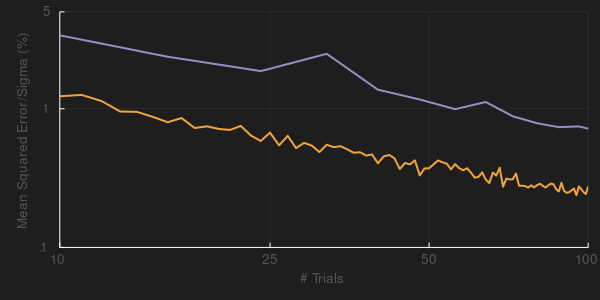

In [6]:
# Sort the staircase values
ReversionX, SortedMean, SortedSTD, SortedError = SortedStaircaseStatistics(staircase_num_revs_t_est, staircase_num_revs_t_stop,
 target_amplitude)
# Plot the error as a function of trials
ErrorComparisonPlot = plot(xlabel = "# Trials", ylabel = "Mean Squared Error/Sigma (%)", xlim=(10, 100),
 size=(500,350), bottom_margin=5mm, left_margin=5mm, xscale=:log10, yscale=:log10, ylim=(.1, 5),
 xticks=([10, 25, 50, 100], ["10", "25", "50", "100"]), yticks=([.1, 1, 5], [".1", "1", "5"]))
plot!(ErrorComparisonPlot, collect(1:max_repeats_per_intensity).*length(test_stims), t_error_uconsts./sigma,
 linecolor=ColorSchemes.PuOr_3[3], linewidth=2)
plot!(ErrorComparisonPlot, ReversionX, SortedError./sigma, linecolor=ColorSchemes.PuOr_3[1], linewidth=2, size=(600, 300))

Perhaps as expected, we see that the error decreases as a function of # trials for both and that the error is substantially lower for the staircase method than the naive constants for the same number of trials. Indeed, for the error to be within 100% of the sigma value you need 25 trials for the staircase but ~100 for constants.

##### Opimizing the Method of Constants
One reason that the method of constants performs relatively poorly is because it's the worst possible version of it. For the example we are using with 12 stimulus levels, the first and last 3 intensities all contain redundant information as the p(Detected) is the same for those values due to the asymtotic nature of an ogival (CDF like) function. In a naive setting, this is unaviodable as we have no prior expectations on what the detection threshold should be. In the context of BCI, however, we often repeat the threshold measurement on each electrode every few months and sometimes more often. In these cases then we will have a prior assumption about what stimulus levels to test at and that would allow us to constrain the stimulus levels used in the method of constants to a more appropriate range. First, however, this means we must determine what the optimal range and sampling density is for a given psychometric curve. Another, constraint/assumption we can add is to append values to the sigmoid fit to reduce noise. For example, we can add a point at the lower and upper bound with a p(Detected) of 0 and 100 respectively.

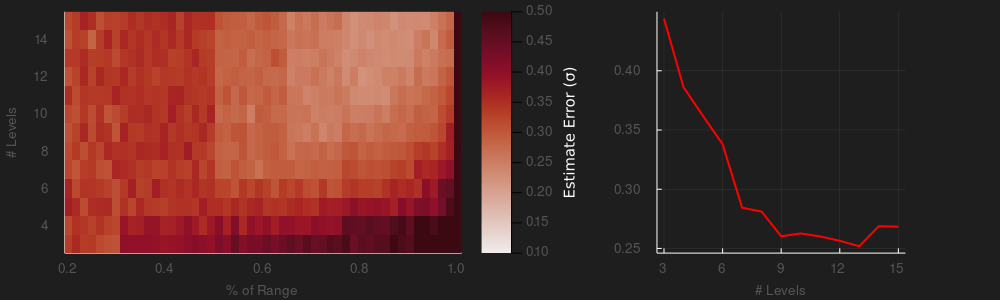

In [7]:
num_repeats = 10 # The exact number doesn't matter as it's all relative
num_levels = 3:15 # How many stimulus levels to use (centered around DT)
widths = range(0.2,1,50) # What proportion of the psychometric curve should we sample 
t_mean_optim = fill(NaN, length(num_levels), length(widths))
t_std_optim = fill(NaN, length(num_levels), length(widths))
t_error_optim = fill(NaN, length(num_levels), length(widths))

# Here we will get new stimulus levels for each number of intensities and width of the curve
for (lidx,l) in enumerate(num_levels)
    for (widx,w) in collect(enumerate(widths)) # 
        test_stims, test_stims_pDetected = GetConstantTargets(valid_stims, pDetected,
        Mode = "Constrained", NumStimLevels = l, PsychRange = [0.5-w/2, 0.5+w/2])
        t_pred, _ = ConstantSimulation(test_stims, test_stims_pDetected, num_repeats, NumPermutations = num_constant_perms,
         BoundSig = true)
        t_mean_optim[lidx,widx] = nanmean(t_pred)
        t_std_optim[lidx,widx] = nanstd(t_pred)
        t_error_optim[lidx,widx] = nanmean(abs.(t_pred .- detection_threshold))
    end
end


optim_heatmap = plot(xlabel = "% of Range", ylabel = "# Levels")
    heatmap!(optim_heatmap, widths, num_levels, t_error_optim./sigma, c=:amp, colorbar=true,
    colorbar_title="Estimate Error (MES/σ)", clim=(.1, .5),  ylim=(2.5, num_levels[end]+.5))

# The heatmap shows that at 0.68 width (1 standard deviation) then improvements taper
# Though performance improves with # levels we can't indefinitely add that as it will make
# trials take longer so lets see where it asymptotes
(_,idx) = findmin(abs.(widths .- 0.68))
num_levels_optim_plot = plot(xlabel = "# Levels")
    plot!(num_levels, t_error_optim[:,idx]./sigma, linecolor=:red, xticks=3:3:15)

l = @layout [a{0.6w} b{0.3w}]
plot(optim_heatmap, num_levels_optim_plot,
 bottom_margin=5mm, left_margin=5mm, layout=l, size=(1000, 300))

We see that the best estimate occurs once we've reached 0.68 width (1 standard deviation) and at roughly 8-10 levels. The number of levels is less reliable as we do not have infinite stimulus levels in a given range. For example, if the JND/IQR is 3 μA then you ideally only want to sample a 6 μA range, which only has 3 points.

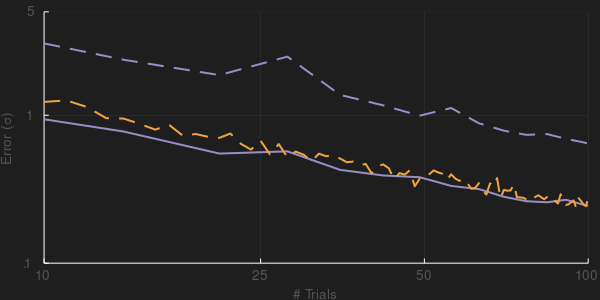

In [8]:
# Define new values
test_stims, test_stims_pDetected = GetConstantTargets(valid_stims, pDetected, Mode = "Constrained", PsychRange = [0.175, 0.825])
# Repeat the analysis
# Simulate the method of constants
constant_num_trials_t_est_optim = fill(NaN, max_repeats_per_intensity, num_constant_perms)
Threads.@threads for MaxReps = 1:max_repeats_per_intensity
    constant_num_trials_t_est_optim[MaxReps,:], _ = ConstantSimulation(test_stims, test_stims_pDetected,
    MaxReps, NumPermutations = num_constant_perms, NumAFC = 2, BoundSig=true)
end
# Compute stats across permutations
t_mean_uconsts_optim = vec(nanmean(constant_num_trials_t_est_optim, dims = 2))
t_std_uconsts_optim = vec(nanstd(constant_num_trials_t_est_optim, dims = 2))
t_error_uconsts_optim = vec(nanmean(abs.(constant_num_trials_t_est_optim .- detection_threshold), dims = 2));

ErrorComparisonPlot = plot(xlabel = "# Trials", ylabel = "Error (σ)", xlim=(10, 100),
 size=(500,350), xscale=:log10, yscale=:log10, ylim=(.1, 5),
 xticks=([10, 25, 50, 100], ["10", "25", "50", "100"]), yticks=([.1, 1, 5], [".1", "1", "5"]))
# Naive Constants
plot!(ErrorComparisonPlot, collect(1:max_repeats_per_intensity).*length(test_stims), t_error_uconsts./sigma,
 linecolor=ColorSchemes.PuOr_3[3], linewidth=2, linestyle=:dash)
# Optimized Constants
plot!(ErrorComparisonPlot, collect(1:max_repeats_per_intensity).*length(test_stims), t_error_uconsts_optim./sigma,
 linecolor=ColorSchemes.PuOr_3[3], linewidth=2)
# Naive 3U1D tStaircase
plot!(ErrorComparisonPlot, ReversionX, SortedError./sigma, linecolor=ColorSchemes.PuOr_3[1], linewidth=2, linestyle=:dash, size=(600, 300))

With this simple optimization we can see that the staircase and the constants method are now equivalent in terms of performance.

##### Optimizing the Transformed Staircase
If we are going to use a prior estimate of the threshold for Optimized Constants, then it is only reasonable to do the same with the Transformed staircase. Therefor, we can re-run the simulation starting at the correct location and halving the initial step size so that it converges quicker.
We can also test certain convergence parameters to see what effect they have and if we can find an optimal ratio.

Opimizations we'll examine here:
1. Initalizing at previous threshold
2. Step size parameters
3. Skipping initial reversions
4. Using maximum likelihood estimation (MLE) for threshold estimation

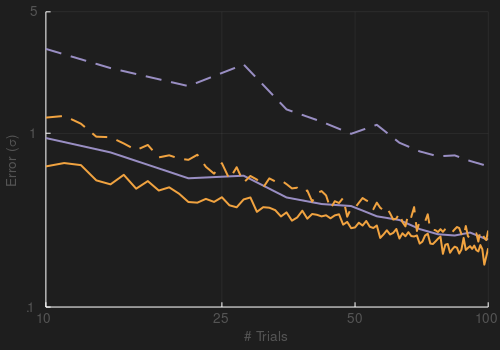

In [9]:
### 1. Initalize at target amplitude
# Repeat previous code but use the "InitAmp" parameter to start the staircase in the correct place
staircase_num_revs_t_est_optim_init = fill(NaN, max_num_reversions, num_stair_perms) 
staircase_num_revs_t_stop_optim_init = fill(NaN, max_num_reversions, num_stair_perms)
Threads.@threads for MaxReversions = 3:max_num_reversions
  _, _, _, staircase_num_revs_t_est_optim_init[MaxReversions,:], staircase_num_revs_t_stop_optim_init[MaxReversions,:] =
   TransformedStaircaseSimulation(valid_stims, pDetected, MaxReversions = MaxReversions, NumPermutations = num_stair_perms, NumAFC = 2,
   SkipFirstNReversions = 2, InitAmp = Int(round(target_amplitude)), InitStepSize = 10)
end
# Compute stats across permutations
ReversionX_optim1, _, _, SortedError_optim1 = SortedStaircaseStatistics(staircase_num_revs_t_est_optim_init,
 staircase_num_revs_t_stop_optim_init, target_amplitude)

ErrorComparisonPlot = plot(xlabel = "# Trials", ylabel = "Error (σ)", xlim=(10, 100),
 size=(500,350), xscale=:log10, yscale=:log10, ylim=(.1, 5),
 xticks=([10, 25, 50, 100], ["10", "25", "50", "100"]), yticks=([.1, 1, 5], [".1", "1", "5"]))
  # Naive Constants
  plot!(ErrorComparisonPlot, collect(1:max_repeats_per_intensity).*length(test_stims), t_error_uconsts./sigma,
  linecolor=ColorSchemes.PuOr_3[3], linewidth=2, linestyle=:dash)
  # Optimized Constants
  plot!(ErrorComparisonPlot, collect(1:max_repeats_per_intensity).*length(test_stims), t_error_uconsts_optim./sigma,
  linecolor=ColorSchemes.PuOr_3[3], linewidth=2)
  # Naive 3U1D tStaircase
  plot!(ErrorComparisonPlot, ReversionX, SortedError./sigma, linecolor=ColorSchemes.PuOr_3[1], linewidth=2, linestyle=:dash)
  # Optim1 3U1D tStaircase
  plot!(ErrorComparisonPlot, ReversionX_optim1, SortedError_optim1./sigma, linecolor=ColorSchemes.PuOr_3[1], linewidth=2)


The initial step size optimization, unsurprisingly, improves performance, though not drastically. Importantly, both 'optimized' methods so far use a perfect prior estimate and do not account for variance that may occur from poor initalization. The next step is to look at convergence. The step size of the staircase reduces by a given amount on each reversion and so the amount that it changes is dependent on the reversion number. At some point the step size reaches a minimum value (in our case 2 μA) and the staircase will only move by that amount from that point onwards. Other staircase methods (e.g. PEST) allow for increasing step size. If the step size reduces too quickly or too slowly then the number of trials required to converge will be large. Thus, we can examine what the optimal ratio is for a given staircase scenario. It's worth noting that when the staircase is initalized far away from the threshold then very few reversions will occur until closer to the threshold and so an overly small step size is not necessarily catastrophic.

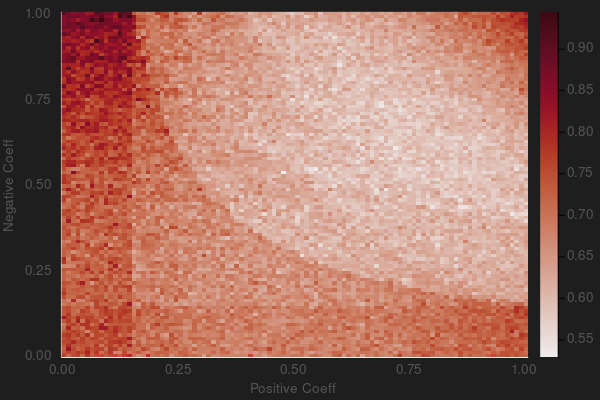

In [10]:
# Now let's look at step size parameters (without the initial step size parameter)
IncreaseStepCoeff = range(0, 1, 100)
DecreaseStepCoeff = range(0, 1, 100)
# We'll also set a hard stop on the max_trials
max_trials = 50
staircase_tmean_coeffs = fill(NaN, length(IncreaseStepCoeff), length(IncreaseStepCoeff))
staircase_terror_coeffs = fill(NaN, length(IncreaseStepCoeff), length(IncreaseStepCoeff))
for (iidx, ISC) in enumerate(IncreaseStepCoeff)
    for (didx, DSC) in enumerate(DecreaseStepCoeff)
        _, _, _, temp_t_est, _ = TransformedStaircaseSimulation(valid_stims, pDetected, MaxReversions = 7, NumPermutations = num_stair_perms,
        SkipFirstNReversions = 2, IncreaseStepCoeff = ISC, DecreaseStepCoeff = DSC, MaxTrials = max_trials)
        staircase_tmean_coeffs[iidx, didx] = nanmean(temp_t_est)
        staircase_terror_coeffs[iidx, didx] = nanmean(abs.(temp_t_est .- target_amplitude))
    end
end

optim_heatmap = plot(xlabel = "Positive Coeff", ylabel = "Negative Coeff")
    heatmap!(optim_heatmap, IncreaseStepCoeff, DecreaseStepCoeff, staircase_terror_coeffs./sigma, c=:amp, colorbar=true)

Unsurprisingly, perhaps, the default settings of 0.75 for both coefficients is already optimal, at least for a random starting position and a detection threshold in the middle of the valid stimulus range. Given this, there is no need to compare the st

The next thing to check is how skipping reversions might effect convergence. The default practice is to skip the first 2 reversions as people argue that they are those which are least likely to be near the threshold due to large step sizes, however we can test if that's truly the correct number. Again, to keep the comparison fair we will keep the total trials the same and use the default stop criteria of 7 reversions.

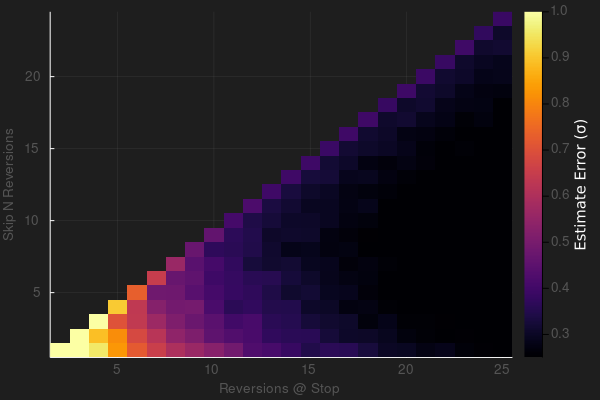

In [11]:
max_reversions = 2:25
staircase_tmean_nskips = fill(NaN, length(max_reversions), length(max_reversions))
staircase_terror_nskips = fill(NaN,  length(max_reversions), length(max_reversions))
for (iidx,i) in enumerate(max_reversions)
    num_reversions_to_skip = 1:i-1
    for (jidx, j) in enumerate(num_reversions_to_skip)
        _, _, _, temp_t_est, _ = TransformedStaircaseSimulation(valid_stims, pDetected, MaxReversions = i,
            NumPermutations = num_stair_perms, SkipFirstNReversions = j, UseMLE = false)
        staircase_tmean_nskips[iidx,jidx] = nanmean(temp_t_est)
        staircase_terror_nskips[iidx,jidx] = nanmean(abs.(temp_t_est .- target_amplitude))
    end
end

heatmap(max_reversions, 1:max_reversions[end]-1, staircase_terror_nskips'./sigma,
 xlabel="Reversions @ Stop", ylabel="Skip N Reversions", colorbar=:true, clim=(.25, 1), colorbar_title="Estimate Error (σ)")

This heatmap reveals that the number of reversions we should ignore is actually dependent upon the maximum number of reversions. In a short staircase where we only expect convergence to occur near the end we can expect that the reversions closest to the end of the staircase will be the closest and so ignoring all except the last 2 is ideal. On longer staircases where convergence occurs early or mid-way through, however, though early reversions harm our estimate, discarding too many has a similar effect. Essentially, one should aim to take all reversions after we expect convergence to have occurred to prevent including erroneous data without losing informative data.

Finally, we can look at how different estimation methods perform across criteria. Some authors have suggested that using MLE on the entire history (note\*: only reversions) solves the problem of knowing how many reversion values to include or ignore.

\* Using MLE on non-reversion amplitudes with a 3U/1D staircase causes class imbalancing and heavily biases the logistic fit

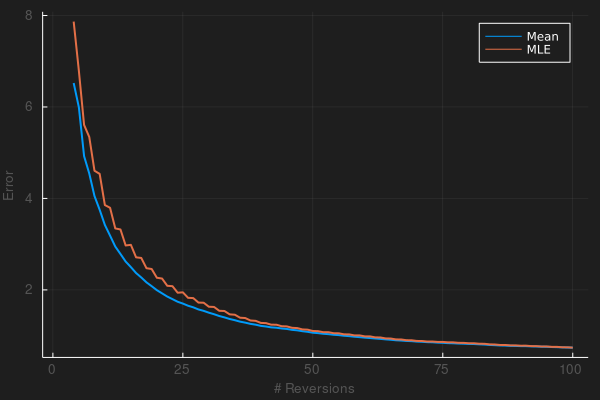

In [41]:
# We'll run a staircase simulation but this time keep the amplitude and reversion values
max_reversions = 100
amplitude_history, detection_history, reversion_history, _, stop_point =
        TransformedStaircaseSimulation(valid_stims, pDetected, NumPermutations = num_stair_perms, MaxReversions = max_reversions)

# We can then post-hoc look at how each estimation method would work on the same staircases
ReversionAveragingError = fill(NaN, max_reversions)
MLEError = fill(NaN, max_reversions)
for i = 4:max_reversions
        # No MLE
        RevThresholds = PosthocEstimateStaircaseThreshold(amplitude_history, reversion_history,
                MaxReversions = i, SkipFirstNReversions = 2, UseMLE = false)
        ReversionAveragingError[i] = nanmean(abs.(RevThresholds .- target_amplitude))
        # With MLE
        (MLEThresholds, MLESigmas) = PosthocEstimateStaircaseThreshold(amplitude_history, reversion_history,
                MaxReversions = i, UseMLE = true)
        MLEError[i] = nanmean(abs.(MLEThresholds .- target_amplitude))
end

MLE_ErrorPlot = plot(xlabel = "# Reversions", ylabel = "Error", legend=true)
plot!(MLE_ErrorPlot, 1:max_reversions, ReversionAveragingError, label = "Mean")
plot!(MLE_ErrorPlot, 1:max_reversions, MLEError, label = "MLE")

Here we see that MLE actually doesn't seem to improve threshold predictions at all and, if anything, makes them slightly worse. However, one thing that MLE does add is that you can gain an estimate of the IQR, thus, given that they perform equivalently, we can compare the IQR estimate from the staircase and constants method.

### PEST

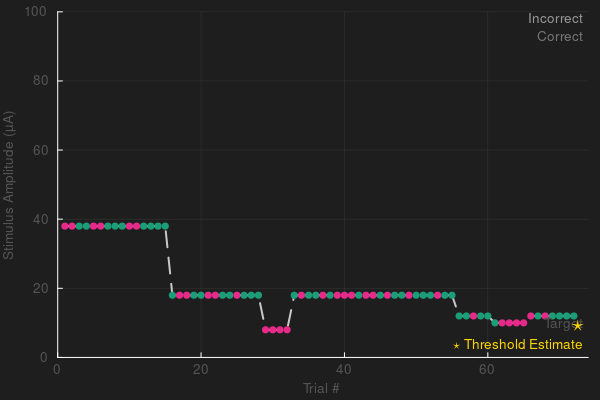

In [55]:
num_afc = 2
target_performance = .50
# Single staircase simulation
amplitude_history, detection_history, reversion_history, estimated_thresholds, stop_point = 
 PESTStaircaseSimulation(valid_stims,  pDetected, MaxReversions = 7, NumPermutations = 1, NumAFC = num_afc, UseMLE = false,
 TargetPerformance = target_performance) 
# Identify which trials were correct/incorrect
term_idx = findfirst(isnan.(amplitude_history))[1]
correct_idx = findall(vec(detection_history[1:term_idx]) .== 1)
incorrect_idx = findall(vec(detection_history[1:term_idx]) .== 0)

pest_target = GetPESTStaircaseTarget(psychometric_pdf, target_performance, 2)

# Make the plot
StaircaseExamplePlot = plot(xlabel = "Trial #", ylabel = "Stimulus Amplitude (μA)",
  xlim=(0, term_idx+1), ylim=(0,100))
  # Show target/convergence point
  plot!(StaircaseExamplePlot, [0,term_idx+1], [pest_target, pest_target],
   color="rgb(200,200,200)", linestyle=:dot)
  # Show trial history
  plot!(StaircaseExamplePlot, 1:term_idx, amplitude_history[1:term_idx],
   color="rgb(200,200,200)", linestyle=:dash)
  scatter!(StaircaseExamplePlot, correct_idx, amplitude_history[correct_idx],
   markercolor=ColorSchemes.Dark2_3[1],
  markerstrokecolor=ColorSchemes.Dark2_3[1])
  scatter!(StaircaseExamplePlot, incorrect_idx, amplitude_history[incorrect_idx],
   markercolor=ColorSchemes.Dark2_4[4],
  markerstrokecolor=ColorSchemes.Dark2_4[4])
  # Annotations
  annotate!(StaircaseExamplePlot, term_idx+0.5, 100, "Incorrect",
  annotationhalign=:right, annotationvalign=:top, annotationcolor=ColorSchemes.Dark2_4[4])
  annotate!(StaircaseExamplePlot, term_idx+0.5, 95, "Correct",
  annotationhalign=:right, annotationvalign=:top, annotationcolor=ColorSchemes.Dark2_3[1])
  annotate!(StaircaseExamplePlot, term_idx+0.5, 8, "Target",
  annotationhalign=:right, annotationvalign=:bottom, annotationcolor="rgb(200,200,200)")
  annotate!(StaircaseExamplePlot, term_idx+0.5, 2, "⋆ Threshold Estimate",
  annotationhalign=:right, annotationvalign=:bottom, annotationcolor=:gold)
  annotate!(StaircaseExamplePlot, term_idx+0.5, estimated_thresholds[1], "⋆",
  annotationhalign=:right, annotationvalign=:center, annotationcolor=:gold, annotationfontsize=15)


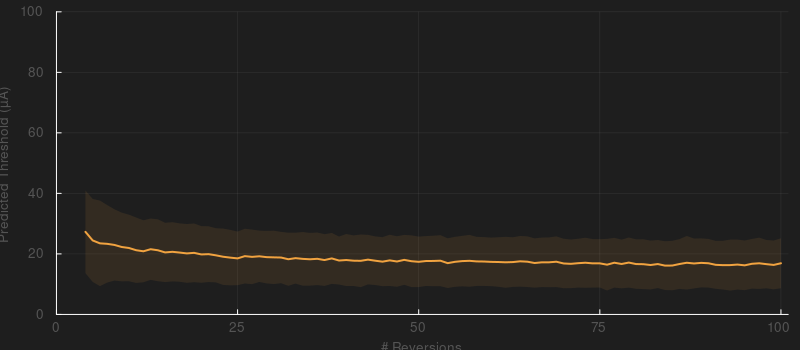

In [56]:
# Now let's look at how accuracy changes as a function of # reversions
max_num_reversions = 100 # Similarly excessive
# Repeat for the staircase and number of reversions
staircase_num_revs_t_est = fill(NaN, max_num_reversions, num_stair_perms)
staircase_num_revs_t_stop = fill(NaN, max_num_reversions, num_stair_perms)
Threads.@threads for MaxReversions = 4:max_num_reversions
  _, _, _, staircase_num_revs_t_est[MaxReversions,:], staircase_num_revs_t_stop[MaxReversions,:] =
   PESTStaircaseSimulation(valid_stims, pDetected, MaxReversions = MaxReversions, NumPermutations = num_stair_perms, NumAFC = num_afc,
   UseMLE = false, TargetPerformance = target_performance)
end
# Compute stats across permutations
t_mean_tstairs = vec(nanmean(staircase_num_revs_t_est, dims = 2))
t_std_tstairs = vec(nanstd(staircase_num_revs_t_est, dims = 2))
t_error_tstairs = vec(nanmean((staircase_num_revs_t_est .- pest_target).^2, dims = 2))


StaircaseNumReversionsPlot = plot(xlabel = "# Reversions", ylabel = "Predicted Threshold (μA)",
  xlim=(0, max_num_reversions+1), ylim=(0,100), size=(800,350))
  plot!(StaircaseNumReversionsPlot, collect(1:max_num_reversions), t_mean_tstairs, ribbon=t_std_tstairs,
   fillalpha=0.1, linewidth=2, linecolor=ColorSchemes.PuOr_3[1], fillcolor=ColorSchemes.PuOr_3[1])

# plot(StaircaseExamplePlot, StaircaseNumReversionsPlot, bottom_margin=5mm, left_margin=5mm, size=(800, 300))
